<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/Other_features_dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [2]:
pip install geotext


     |████████████████████████████████| 2.0 MB 30.4 MB/s 


In [9]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
from geotext import GeoText
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


#Load Data

In [129]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [284]:
is_r = list()
for i in df['Age rate']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)
print(is_r.count(0), ":", is_r.count(1))

447 : 338


#Remove stopwords and punctuation

In [249]:
#define stop words: english stop words, numbers, male and female names
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 	'thirteen', 'fourteen', 'fifteen', 
'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']
stpwrds = stopwords.words('english') + [i.lower() for i in names.words('male.txt') + names.words('female.txt')] + numbers
data = [n.lower() for n in df['Name of movie']]
for i in range(len(data)):
  data[i] += " " + df['Description'][i].lower()
data2 = []

#remove city names from description
for i in range(len(df['Name of movie'])):
  places = GeoText(df['Name of movie'][i])
  if places.cities != []:
    for j in places.cities:
      data[i] = data[i].replace(j.lower(), '')


for i in data:
  #remove punctuation and split
  tr= str.maketrans(dict.fromkeys(string.punctuation))
  new_i = i.translate(tr)
  descr = new_i.split(sep=' ')

  #remove stop words or numbers
  for k in range(10):
    for j in descr:
      if j in stpwrds or j!= '' and j[0].isdigit():
        descr.remove(j)
    if "" in descr:
      descr.remove("")
  data2.append(descr)

print(df['Name of movie'][348], ": ",df['Description'][348] )
print(data2[348])


The Hitchhiker's Guide to the Galaxy Mere seconds before the Earth is to be demolished by an alien construction crew, journeyman Arthur Dent is swept off the planet by his friend Ford Prefect, a researcher penning a new edition of "The Hitchhiker's Guide to the Galaxy."
['hitchhikers', 'guide', 'galaxy', 'mere', 'seconds', 'earth', 'demolished', 'alien', 'construction', 'crew', 'journeyman', 'dent', 'swept', 'planet', 'friend', 'prefect', 'researcher', 'penning', 'new', 'edition', 'hitchhikers', 'guide', 'galaxy']


#Stem words

In [285]:
stemmer = PorterStemmer()
for i in range(len(data2)):
  data2[i] = [stemmer.stem(w.lower()) for w in data2[i]]
print(data2[3])

['godfath', 'part', 'ii', 'earli', 'life', 'career', 'corleon', 'new', 'york', 'citi', 'portray', 'expand', 'tighten', 'grip', 'famili', 'crime', 'syndic', 'crime', 'drama', '202', '1974', '3']


In [286]:
for i in range(len(data2)):
  data2[i].extend(df['Genre'][i].replace(' ', '').lower().split(','))
  data2[i].append(str(df['Runtime'][i]))
  data2[i].append(str(df['Year'][i]))
  data2[i].append(str(df['Unnamed: 0'][i]))
print(data2)
short_df = pd.DataFrame(list(zip(data2, is_r)),
               columns =['name', 'age rate'])

short_df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(short_df)

[['shawshank', 'redempt', 'imprison', 'men', 'bond', 'number', 'year', 'find', 'solac', 'eventu', 'redempt', 'act', 'common', 'decenc', 'drama', '142', '1994', '0', 'drama', '142', '1994', '0'], ['godfath', 'godfath', 'follow', 'corleon', 'corleon', 'famili', 'pass', 'mantel', 'crime', 'drama', '175', '1972', '1', 'crime', 'drama', '175', '1972', '1'], ['pulp', 'fiction', 'live', 'mob', 'hitmen', 'boxer', 'gangster', 'wife', 'pair', 'diner', 'bandit', 'intertwin', 'tale', 'violenc', 'redempt', 'crime', 'drama', '154', '1994', '2', 'crime', 'drama', '154', '1994', '2'], ['godfath', 'part', 'ii', 'earli', 'life', 'career', 'corleon', 'new', 'york', 'citi', 'portray', 'expand', 'tighten', 'grip', 'famili', 'crime', 'syndic', 'crime', 'drama', '202', '1974', '3', 'crime', 'drama', '202', '1974', '3'], ['incept', 'thief', 'steal', 'corpor', 'secret', 'use', 'dreamshar', 'technolog', 'given', 'inver', 'task', 'plant', 'idea', 'mind', 'ceo', 'tragic', 'past', 'doom', 'project', 'team', 'disas

,name,age rate
0,"[shawshank, redempt, imprison, men, bond, numb...",1
1,"[godfath, godfath, follow, corleon, corleon, f...",1
2,"[pulp, fiction, live, mob, hitmen, boxer, gang...",1
3,"[godfath, part, ii, earli, life, career, corle...",1
4,"[incept, thief, steal, corpor, secret, use, dr...",0


# Hyperparameters


In [298]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=30

####
# training:
epochs = 4#4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
#n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 





# Tokenizer

In [288]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)
t.fit_on_texts([x for x in short_df['name']])
print(len(t.word_index))
os.makedirs(output_dir, exist_ok=True)
with io.open(output_dir+'/tokenizer.json', 'w',encoding='utf-8', ) as f:
    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1
num_categories = 1


4733


In [289]:
descr_sequences = t.texts_to_sequences([x for x in np.array(short_df['name'])])
descr_sequences = tf.keras.preprocessing.sequence.pad_sequences(descr_sequences, maxlen=maxlen)
print(descr_sequences[0])
print('sequences : ',descr_sequences,'\n')
print('word_index : ',t.word_index)
print(np.array(descr_sequences))

[   0    0    0    0    0    0    0    0 2682  954  717  168  215  955
   73   25  956  957  954  367 2683 2684    2  303   74 1295    2  303
   74 1295]
sequences :  [[   0    0    0 ...  303   74 1295]
 [   0    0    0 ...  498 1296 1297]
 [   0    0    0 ...  369   74 1302]
 ...
 [   0    0    0 ...  397   12 2678]
 [   0    0    0 ...   84   16 2680]
 [ 605  148 4732 ...   96   24 2681]] 

word_index :  {'action': 1, 'drama': 2, 'crime': 3, 'thriller': 4, 'horror': 5, 'comedi': 6, 'comedy': 7, 'adventur': 8, 'adventure': 9, 'sci-fi': 10, 'mysteri': 11, '2007': 12, '2004': 13, '2008': 14, 'famili': 15, '2005': 16, '2003': 17, 'fantasi': 18, 'fantasy': 19, '2002': 20, '2006': 21, '2001': 22, 'mystery': 23, '2009': 24, 'find': 25, 'must': 26, 'romanc': 27, '2000': 28, 'family': 29, 'new': 30, '2010': 31, 'romance': 32, 'man': 33, 'world': 34, 'life': 35, 'young': 36, 'anim': 37, '104': 38, 'group': 39, 'animation': 40, 'war': 41, 'becom': 42, '1999': 43, '101': 44, '1997': 45, 'live':

#Split data into train and test 

In [290]:
X_train, X_test, y_train, y_test = train_test_split(descr_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[1973  182 1974 ...   64   14 1977]
 [ 195   39 2963 ...   68   31   64]
 [   0    0    0 ...  775   13 1439]
 ...
 [   0    0    0 ...   90   16 1835]
 [   0    0   34 ...  209   43 2151]
 [   0    0    0 ...  207   14   89]]


In [291]:
l = len(X_train[363])
print(l)

30


# Model and Train

In [299]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 30, 64)            302976    
                                                                 
 flatten_11 (Flatten)        (None, 1920)              0         
                                                                 
 dense_44 (Dense)            (None, 2000)              3842000   
                                                                 
 dense_45 (Dense)            (None, 500)               1000500   
                                                                 
 dense_46 (Dense)            (None, 100)               50100     
                                                                 
 dense_47 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,195,677
Trainable params: 5,195,677
N

In [300]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [301]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [302]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [303]:
#output
n_dense + 1

65

#Configure model

In [304]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/4
23/23 [==============================] - 4s 104ms/step - loss: 0.6082 - accuracy: 0.6360 - val_loss: 0.6793 - val_accuracy: 0.5949
Epoch 2/4
23/23 [==============================] - 2s 97ms/step - loss: 0.2731 - accuracy: 0.8994 - val_loss: 0.7011 - val_accuracy: 0.6835
Epoch 3/4
23/23 [==============================] - 2s 98ms/step - loss: 0.0141 - accuracy: 0.9972 - val_loss: 1.1397 - val_accuracy: 0.6835
Epoch 4/4
23/23 [==============================] - 2s 97ms/step - loss: 9.5404e-04 - accuracy: 1.0000 - val_loss: 1.4069 - val_accuracy: 0.6835


In [267]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 12ms/step - loss: 1.2547 - accuracy: 0.6962
Test Score: 1.2547452449798584
Test Accuracy: 0.6962025165557861


# Accuracy

In [268]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [269]:
y_hat = model.predict(X_test)

In [270]:
len(y_hat)

79

In [271]:
y_hat[3]

array([0.7798015], dtype=float32)

In [272]:
print(np.array(y_test)[3])

1


In [273]:
print(type(y_hat))

<class 'numpy.ndarray'>


In [274]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'73.77'

In [275]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [276]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(ydf)

       y_hat  y
0   0.002498  0
1   0.145024  0
2   0.116267  1
3   0.779801  1
4   0.911199  0
5   0.934741  0
6   0.002466  0
7   0.161895  0
8   0.317299  1
9   0.076476  1
10  0.127402  0
11  0.988265  1
12  0.983683  1
13  0.803954  1
14  0.085253  0
15  0.901898  1
16  0.013889  1
17  0.111758  0
18  0.006439  0
19  0.714894  0
20  0.000542  0
21  0.002985  0
22  0.120739  1
23  0.909387  1
24  0.024710  1
25  0.239456  1
26  0.008275  0
27  0.399527  0
28  0.866518  1
29  0.937931  1
30  0.820960  0
31  0.052842  1
32  0.000974  0
33  0.168737  0
34  0.532704  1
35  0.902373  1
36  0.292447  1
37  0.069960  1
38  0.081179  0
39  0.853182  1
40  0.761340  1
41  0.968626  1
42  0.000551  0
43  0.207953  0
44  0.001948  0
45  0.065142  1
46  0.013149  1
47  0.896388  1
48  0.795303  1
49  0.509350  1
50  0.005779  0
51  0.002372  0
52  0.006761  0
53  0.005733  0
54  0.771871  1
55  0.047271  0
56  0.329101  0
57  0.076891  0
58  0.937837  1
59  0.331359  1
60  0.000560  0
61  0.05

In [277]:
print(df.iloc[752])
print('Name:', df['Name of movie'][752])
print('Prediction:', y_hat[0])
print("Reality:", y_test.iloc[0])

Unnamed: 0                                                     752
Name of movie                                           Armageddon
Description      After discovering that an asteroid the size of...
Age rate                                                     PG-13
Year                                                          1998
Runtime                                                        151
Genre                        Action, Adventure, Sci-Fi            
Name: 752, dtype: object
Name: Armageddon
Prediction: [0.00249833]
Reality: 0


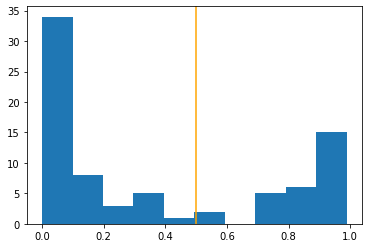

In [278]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [279]:
print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)]))
print(len(y_test))

9
79


In [280]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y_test)

752    0
39     0
211    1
199    1
235    0
215    0
547    0
601    0
299    1
137    1
323    0
218    1
174    1
506    1
168    0
67     1
517    1
688    0
525    0
781    0
753    0
446    0
286    1
335    1
23     1
247    1
599    0
377    0
613    1
429    1
618    0
771    1
490    0
678    0
97     1
346    1
585    1
516    1
692    0
779    1
635    1
350    1
580    0
683    0
653    0
714    1
120    1
86     1
654    1
78     1
621    0
780    0
649    0
49     0
77     1
231    0
433    0
66     0
260    1
329    1
545    0
640    0
30     0
591    1
33     1
31     0
582    0
417    0
314    0
751    0
762    0
676    1
309    0
302    1
705    0
326    0
234    0
606    0
362    1
Name: age rate, dtype: int64


In [281]:
print(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)])

       y_hat  y
9   0.076476  1
16  0.013889  1
24  0.024710  1
31  0.052842  1
37  0.069960  1
45  0.065142  1
46  0.013149  1
63  0.004155  1
71  0.006643  1


In [282]:
print(df.iloc[517])
print('Name:', df['Name of movie'][517])
print('Processed name:', data2[517])
print('Prediction:', y_hat[16])
print("Reality:", y_test.iloc[16])

Unnamed: 0                                                     517
Name of movie                           Rambo: First Blood Part II
Description      Rambo returns to the jungles of Vietnam on a m...
Age rate                                                         R
Year                                                          1985
Runtime                                                         96
Genre                      Action, Adventure, Thriller            
Name: 517, dtype: object
Name: Rambo: First Blood Part II
Processed name: ['rambo', 'first', 'blood', 'part', 'ii', 'rambo', 'return', 'jungl', 'vietnam', 'mission', 'infiltr', 'enemi', 'basecamp', 'rescu', 'american', 'pow', 'still', 'held', 'captiv', 'action', 'adventure', 'thriller', '96', '1985', '517']
Prediction: [0.0138894]
Reality: 1


In [283]:
print(ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)])
print(len(y_test))

       y_hat  y
4   0.911199  0
5   0.934741  0
62  0.924567  0
65  0.953789  0
79


# Load/Save Model

In [243]:
model.save(output_dir+'/model_v003')

INFO:tensorflow:Assets written to: model_output/dense/model_v003/assets
